## Agrupamento de strokes para flashes

O ruído natural que acontece na faixa de 3-30 kc/s consiste em impulsos eletromagnéticos causados pela atividade elétrica da atmosfera da terra, esses impulsos são denominados *sferics* e geralmente estão associados às descargas elétricas atmosféricas, uma vez que os raios atigem picos de potência elevados e se propagam com facilidade na banda (VLF - sigla do inglês, *very low frequency*) [LEWIS; HARVEY; RASMUSSEN, 1960](#). Devido essas características, esses impulsos podem ser detectados pelas redes VLF.

A rede STARNET (*Sferics Timing Ranging Network*) é uma rede que opera em VLF, medindo continuamente o campo elétrico vertical na faixa de 4 a 15 kHz, podendo detectar até 130 *sferics* por segundo e inferir sua localização [MORALES et al., 2014)](#). Neste trabalho, os *sferics* represetarão os *strokes*, os quais serão transformados para *flashes*, que representará os raios nuvem-solo. Os *flashes* serão criados a partir do agrupamento dos *strokes*, para isso será utilizado o algoritmo DBSCAN (*Density-Based Spatial Clustering ofApplication with Noise*).

O DBSCAN é uma algoritmo de aprendizado de máquina não supervisionado proposto por [Ester *et al.* (1996)](#) que tem como intuito criar agrupamentos a partir de um conjunto de dados n-dimensional. Esse algoritmo consiste em realizar agrupamentos por densidade de pontos. A densidade é calculada com base na vizinhança de pontos que é definida por um raio de alcance. O algoritmo inicializa selecionando aleatoriamente um ponto qualquer, calcula sua vizinhaça e repete esse processo de forma recursiva com o ponto mais próximo. Os principais parâmetros desse algoritmo são o $\epsilon$ e $m$, indicando respectivamente o raio máximo da vizinhança e a quantidade mínima de pontos para formar um grupo. É escolhido da vizinhança o algoritmo que tiver a menor distância do ponto selecionado. Os pontos que não forem selecionados são considerados com *outliers*. A Figura [1](https://github.com/AdrianoPereira/goamazon/raw/master/notebooks/images/dbscan-simulation.gif) mostra uma simulação do funcionamento do algoritmo DBSCAN.
![](https://github.com/AdrianoPereira/goamazon/raw/master/notebooks/images/dbscan-simulation.gif)


O agrupamento dos strokes em flashes seguirá as etapas descritas no diagrama da Figura [2](#). Na primeira etapa os dados serão filtrados de acordo com a resolução temporal do radar, neste caso 12 minutos. Para os dados de cada intervalo de tempo será aplicado o algoritmo DBSCAN a fim de agrupar *strokes* que aconteceram em um intervalo de 1 segundo. Cada grupo obtido nesse processo será submetido novamente ao DBSCAN, usando como critério de agrupamento uma distância máxima de 2.5km, os *strokes* agrupados nesse processo, irão compor os respectivos *flashes*. O passo seguinte será obter o ponto central entre cada agrupamento de *strokes*, que indicará as coordenadas do *flash*. Em seguida serão computadas algumas estatísticas do processo, como histograma da frequência do número de *strokes*, frequência da distância entre os *strokes*, média de *strokes* e *flashes* simutâneos, dentre outras. Por fim, serão concatenadas em um *dataframe* todos os *flashes* obtidos, com suas respectivas informações de total de *strokes*, coordenada do *flash*, data e hora. Os valores do parâmetros $\epsilon$ e $m$ do DBSCAN foram configurados de acordo com o trabalho de [Lopes (2019)](#). 

![](https://raw.githubusercontent.com/AdrianoPereira/goamazon/master/notebooks/images/flow-clustring-strokes.png)

Importação das bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import datetime as dt
from sklearn.cluster import DBSCAN as dbs
from sklearn.datasets import make_blobs
from scipy.spatial import distance

**Declaração das funções**

`get_datetimes`: Recebe, respectivamente, as listas com os anos, meses e dias os quais deseja-se obter os intervalos de escaneamento do radar. Retorna uma lista com todos os intervalos diários do escaneamento do radar. 

`get_centroid`: Recebe coordenada (longitude e latitude) dos *strokes* que compõem um *flash*. Retorna a coordenada central entre os pontos, ou seja, a coordenada do *flash*.


In [2]:
def get_datetimes(years=[2014], months=[1], days=[1]):
    hours = np.arange(0, 24)
    minutes = np.arange(0, 60, 12)
    datetimes = list()

    for year in years:
        for month in months:
            for day in days:
                for hour in hours:
                    for minute in minutes:
                        temp =  dt.datetime(year=year, month=month, day=day,
                                            hour=hour, minute=minute, second=0)
                        datetimes.append(temp)
    return datetimes


def get_centroid(points):
    lon, lat = zip(*points)
    n = len(lon)

    return sum(lon)/n, sum(lat)/n

Carrega para o conjunto de dados, com as informações dos *strokes*.

In [3]:
filename = "../data/starnet-20140101.csv"
df = pd.read_csv(filename)
df.head()

,datetime,latitude,longitude,major_ellipse_error,atd_error,quality_control,polarity,number_of_rx,number_of_atd
0,2014-01-01 10:10:17,-10.48713,-74.31112,10917,79.3,2,0,5,10
1,2014-01-01 10:10:17,-10.22817,-74.43401,4586,72.9,2,0,7,21
2,2014-01-01 10:10:19,-11.31107,-73.99319,6372,75.0,2,0,5,10
3,2014-01-01 10:10:22,-10.39714,-74.57610,10445,111.8,2,0,6,15
4,2014-01-01 10:10:28,-11.95903,-72.92451,3658,15.2,0,0,4,6


Convertendo coluna `datetime` para o tipo de dados correto.

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

Inicializa variávei com intervalos diários do escaneamento do radar.

In [5]:
years = [2014]
months = [1]
days = [1]
time_series = get_datetimes(years, months, days)

Transformação dos strokes em *flashes*

Para cada intervalo de escaneamento diário do radar, os dados são agrupados seguindo as condições mencionadas anteriormente, ou seja, tempo 1 segundo e distância máxima de 2.5 km, considerando pelo menos 1 *stroke* para compor o *flash*.

In [6]:
l_time_serie = len(time_series)

col_datetime = list()
col_lon = list()
col_lat = list()
col_nflashs = list()

T_DBSCAN = dbs(eps=0.5, min_samples=1)
L_DBSCAN = dbs(eps=0.025, min_samples=1)

for x in range(0, l_time_serie-1):
    df_scan = df[((df['datetime'] >= time_series[x]) & 
                  (df['datetime'] < time_series[x+1]))]
    if df_scan.empty:
        continue
        
    sec_h = df_scan['datetime'].dt.hour*3600
    sec_m = df_scan['datetime'].dt.minute*60
    sec_s = df_scan['datetime'].dt.second+sec_m+sec_h
    df_scan = df_scan.assign(seconds=sec_s)
    
    data_time = sec_s.values.reshape(-1, 1)
    t_dbs_fit = T_DBSCAN.fit(data_time)
    
    mask_t = np.zeros_like(t_dbs_fit.labels_, dtype=bool)
    mask_t[t_dbs_fit.core_sample_indices_] = True
    
    for label_t in set(t_dbs_fit.labels_):
        idxs_label = np.where(t_dbs_fit.labels_ == label_t)[0]
        df_cluster_t = df_scan.iloc[idxs_label, :]
        
        if df_cluster_t.empty:
            continue
            
        data_loc = df_cluster_t[['longitude', 'latitude']].values
        l_dbs_fit = L_DBSCAN.fit(data_loc)
        
        mask_l = np.zeros_like(l_dbs_fit.labels_, dtype=bool)
        mask_l[l_dbs_fit.core_sample_indices_] = True
        
        for label_l in set(l_dbs_fit.labels_):
            strokes_in_flash = data_loc[mask_l & (l_dbs_fit.labels_ == label_l)]
            
            lon, lat = get_centroid(data_loc)
            col_datetime.append(time_series[x])
            col_lon.append(lon)
            col_lat.append(lat)
            col_nflashs.append(strokes_in_flash.shape[0])
             
#         break
#     break

**Descrição do código do bloco acima.**

A variável do bloco abaixo recebe o comprimento dos intervalos de tempo do escaneamento do radar:
```python
l_time_serie = len(time_series)
```

As listas criadas no bloco abaixo, receberão as informações que irão compor o *dataframe* durante o processamento:
```python
col_datetime = list()
col_lon = list()
col_lat = list()
col_nflashs = list()
```

As variáveis do bloco abaixo recebem as instâncias do DBSCAN com seus respectivos parâmetros. `T_DBSCAN` é o método de agrupamento por tempo e `L_DBSCAN` é o método de agrupamento com os parâmetros de localização.
```python
T_DBSCAN = dbs(eps=0.5, min_samples=1)
L_DBSCAN = dbs(eps=0.025, min_samples=1)
```

O processo de agrupamento é realizado para todos os intervalos de escaneamento do radar.
```python
for x in range(0, l_time_serie-1):
```

No bloco abaixo, a variável `df_scan` recebe os *strokes* do intervalo de escaneamento atual. 
```python
df_scan = df[((df['datetime'] >= time_series[x]) & 
              (df['datetime'] < time_series[x+1]))]
if df_scan.empty:
    continue
```

No bloco abaixo, é calculado o tempo na escala de segundos para todos os dados *strokes* do intervalo atual.
```python
sec_h = df_scan['datetime'].dt.hour*3600
sec_m = df_scan['datetime'].dt.minute*60
sec_s = df_scan['datetime'].dt.second+sec_m+sec_h
df_scan = df_scan.assign(seconds=sec_s)
```

No bloco abaixo, os dados são convertidos em uma matriz unidimensional, e agrupados pela sua restrinção de tempo.
```python
data_time = sec_s.values.reshape(-1, 1)
t_dbs_fit = T_DBSCAN.fit(data_time)
```

No bloco abaixo, é criada uma máscara para recuperar os agrupamentos a partir da sua identificação.
```python
mask_t = np.zeros_like(t_dbs_fit.labels_, dtype=bool)
mask_t[t_dbs_fit.core_sample_indices_] = True
```

No bloco abaixo, é iniciado a interação por todos os agrupamentos de tempo, para que seja aplicado o agrupamento por localização.
```python
for label_t in set(t_dbs_fit.labels_):
```

No bloco abaixo, são filtrados somente os registros do agrupamento de tempo atual.
```python
idxs_label = np.where(t_dbs_fit.labels_ == label_t)[0]
df_cluster_t = df_scan.iloc[idxs_label, :]

if df_cluster_t.empty:
    continue
```

No bloco abaixo, os dados são agrupados de acordo com sua localização.
```python
data_loc = df_cluster_t[['longitude', 'latitude']].values
l_dbs_fit = L_DBSCAN.fit(data_loc)
```

No bloco abaixo, é criada a mascara para a selação do novo grupo, e em seguinda são concatenados nas listas que irão compor o *dataframe*.
```python
mask_l = np.zeros_like(l_dbs_fit.labels_, dtype=bool)
mask_l[l_dbs_fit.core_sample_indices_] = True

for label_l in set(l_dbs_fit.labels_):
    strokes_in_flash = data_loc[mask_l & (l_dbs_fit.labels_ == label_l)]

    lon, lat = get_centroid(data_loc)
    col_datetime.append(time_series[x])
    col_lon.append(lon)
    col_lat.append(lat)
    col_nflashs.append(strokes_in_flash.shape[0])
```

Exibição do cabeçalho do *dataframe* contendo os *flashes* calculados.

In [9]:
new_df = pd.DataFrame({'datetime': col_datetime, 'lon': col_lon, 'lat': col_lat, 'strokes': col_nflashs})
new_df.head()

,datetime,lon,lat,strokes
0,2014-01-01,-73.356810,-4.42759,1
1,2014-01-01,-73.559995,-0.05591,1
2,2014-01-01,-73.559995,-0.05591,1
3,2014-01-01,-73.859720,-0.03174,1
4,2014-01-01,-66.595700,-0.22699,1


Obtenção das estatíticas dos *flashes*.

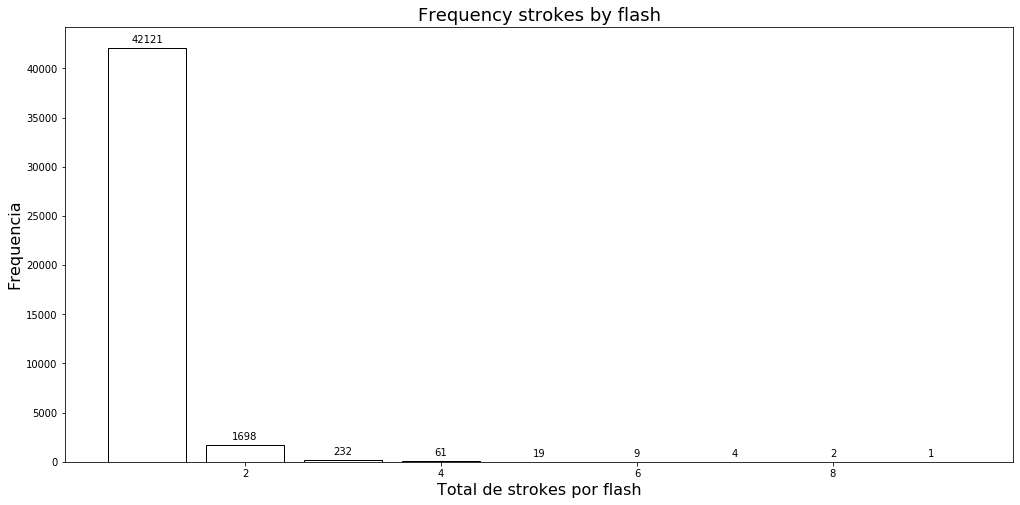

In [8]:
flashs_by_strokes = dict()
for stroke in new_df['strokes'].unique():
    flashs_by_strokes[stroke] = new_df.query("strokes == %d"%stroke).count()[0]

plt.figure(figsize=(17, 8))
plt.title('Frequency strokes by flash', fontdict=dict(size=18))
recs = plt.bar(flashs_by_strokes.keys(), flashs_by_strokes.values(), ec='k', fc='w', lw=1)
for rec in recs:
    height = rec.get_height()
    plt.annotate('{}'.format(height),
                xy=(rec.get_x() + rec.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.xlabel('Total de strokes por flash', fontdict=dict(size=16))
plt.ylabel('Frequencia', fontdict=dict(size=16))
plt.savefig('frequency_flashs.png', dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)